In [805]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, scipy, math, sklearn
import pickle as pkl
from collections import Counter, OrderedDict

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
data_directory = main_directory + 'data' + '\\'
processed_data_directory = data_directory + r'processed data' + '\\'
model_directory = data_directory + r'models' + '\\'

In [806]:
business_df_latest = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
business_df = pd.read_csv(processed_data_directory + 'business_df.csv')
review_df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [807]:
from sklearn import datasets, tree, utils, model_selection, ensemble
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [808]:
from yelpapi import YelpAPI
# get yelp api key stored in txt file
f = open(data_directory + 'yelp_api_key.txt','r')
api_key = f.read()
f.close()

In [809]:
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})

# bag of words model

Regression is tricky with little data. Let's classify each inspection to the nearest 1, and try that.

In [668]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [6]:
yy = np.array(df['Score'])
print(f'{sum(yy%1 != 0.0)}/{len(yy)} ({sum(yy%1 != 0.0)/len(yy)*100}%) are fractional scores')

4184/570614 (0.7332452410911755%) are fractional scores


rounding each score to the ones digit only changes <1% of the scores. This shouldn't change much.

## build single review model

### feature engineering

In [116]:
# # let's just look at businesses with >100 reviews
# num_reviews = df.business_id.value_counts()
# valid_businesses = num_reviews[num_reviews >= 100].index
# df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [117]:
# # only look at outraged customers
# df = df[df.review_stars <= 3]

In [669]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))
# classify into two categories
# thresh = 80
# y = np.array(list(map(lambda x: 1 if x > thresh else 0, y)))

In [43]:
# simple bag of words
bow_vectorizer = TfidfVectorizer(min_df=10,
                                 max_df=0.5,
                                 max_features=20000,
                                 ngram_range=(1,2),
                                 stop_words=STOP_WORDS)
# svd = TruncatedSVD(n_components=100)
features = Pipeline([
    ('tfidf',bow_vectorizer),
    ('svd',TruncatedSVD(n_components=200)),
    ('minmax',MinMaxScaler(feature_range=(0,1))) # necessary for NB
])

In [44]:
# # looking at high tf-idf terms
# high_value_terms = dict(zip(features.named_steps.tfidf.vocabulary_, features.named_steps.tfidf.idf_))
# high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=False))
# high_value_terms

In [45]:
%%time
X_out = features.fit_transform(X,y)

Wall time: 5min 1s


In [46]:
X_out_shuff, y_shuff = shuffle(X_out, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_out_shuff, y_shuff, test_size=0.2)

In [175]:
# save to file
filename = model_directory + 'individual_review_features.pkl'
# pkl.dump(features, open(filename,'wb'))

make sure pickling worked

In [ ]:
filename = model_directory + 'individual_review_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))

In [177]:
X_out_2 = loaded_features.transform(X)

In [181]:
# they're the same, so pickling works
sum(sum(X_out - X_out_2))

-6.583995501574513e-13

### test different models

In [48]:
def test_regressor(regressor,print_R2=True,residual_hist=True,predictions_hist=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()

R^2 score: 0.1199595208057419


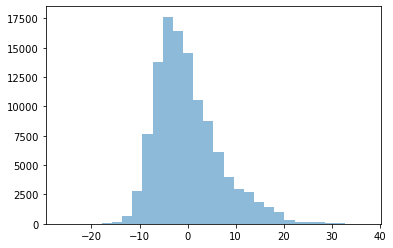

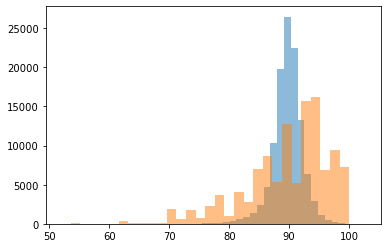

Wall time: 4.3 s


In [49]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R^2 score: 0.14601789297512333


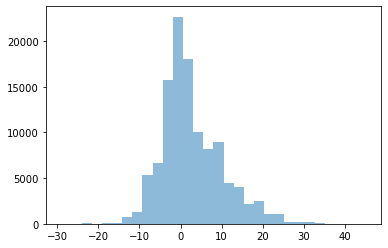

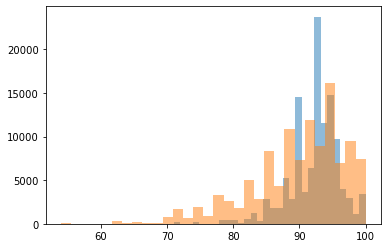

Wall time: 4min 19s


In [138]:
%%time
regressor = LogisticRegression(solver = 'lbfgs', max_iter=100)
test_regressor(regressor)

In [52]:
%%time
parameters = {
    'alpha': [0.01,0.1,1,10]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

Wall time: 17.2 s


{'alpha': 10}

R^2 score: 0.0871341519711938


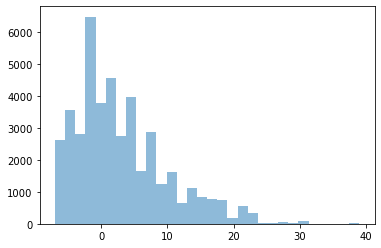

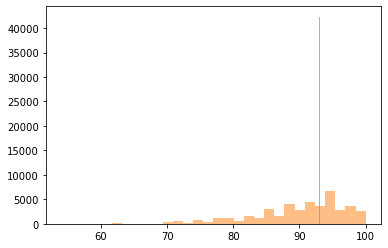

Wall time: 1.09 s


In [ ]:
# %%time
# regressor = MultinomialNB()
# test_regressor(regressor)

In [128]:
# priors = OrderedDict(sorted(Counter(y_test).items()))
# priors = np.fromiter(priors.values(), dtype=float)/len(y_test)

In [236]:
%%time
# regressor = GaussianNB(priors=priors, var_smoothing=0.8)
regressor = GaussianNB(var_smoothing=0.001)
test_regressor(regressor)

KeyboardInterrupt: 

In [233]:
regressor.score(X_out,y)

0.0961245255111161

In [234]:
from sklearn.metrics import r2_score
r2_score(y, regressor.predict(X_out))

-2.8772872852905915

In [132]:
%%time
parameters = {
    'var_smoothing': np.logspace(-9,1,11)
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Wall time: 4min 48s


{'var_smoothing': 0.001}

### Ridge

R^2 score: 0.1199595208057419


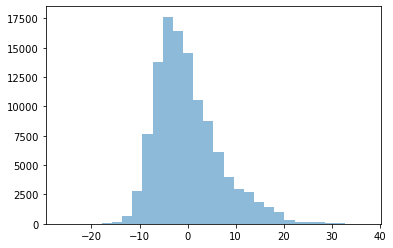

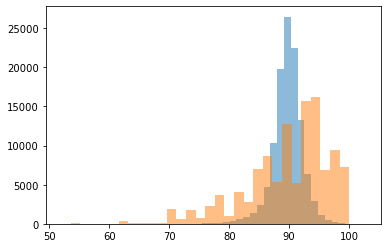

Wall time: 4.44 s


In [53]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

In [54]:
regressor.score(X_out,y)

0.12217979451820682

In [55]:
from sklearn.metrics import r2_score
r2_score(y, regressor.predict(X_out))

0.12217979451820682

In [57]:
# sklearn.metrics.accuracy_score(y, regressor.predict(X_out))

In [58]:
filename = model_directory + 'individual_review_model_ridge.pkl'
pkl.dump(regressor, open(filename,'wb'))

### final model: logistic regression

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R^2 score: 0.14867292307422694


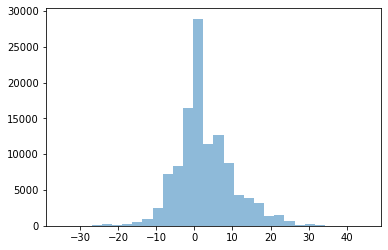

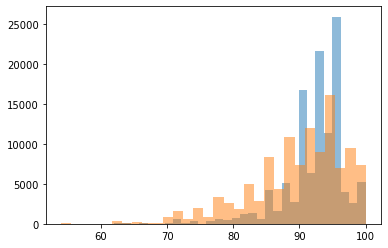

Wall time: 9h 6min 37s


In [139]:
%%time
regressor = LogisticRegression(solver = 'lbfgs', max_iter=500)
test_regressor(regressor)

In [153]:
filename = model_directory + 'individual_review_model.pkl'
# pkl.dump(regressor, open(filename,'wb'))

In [154]:
loaded_model = pkl.load(open(filename, 'rb'))

(array([6.0000e+01, 0.0000e+00, 5.0000e+00, 1.9000e+01, 6.0000e+00,
        3.1700e+02, 1.1200e+02, 1.7900e+02, 9.3000e+01, 6.8000e+01,
        8.1100e+02, 1.6540e+03, 6.6200e+02, 1.9350e+03, 8.9300e+02,
        3.3440e+03, 2.6190e+03, 1.8600e+03, 5.0210e+03, 2.8540e+03,
        8.3090e+03, 4.3070e+03, 1.0821e+04, 7.3370e+03, 1.1938e+04,
        8.9340e+03, 1.6191e+04, 6.9460e+03, 9.4500e+03, 7.3780e+03]),
 array([ 54.        ,  55.53333333,  57.06666667,  58.6       ,
         60.13333333,  61.66666667,  63.2       ,  64.73333333,
         66.26666667,  67.8       ,  69.33333333,  70.86666667,
         72.4       ,  73.93333333,  75.46666667,  77.        ,
         78.53333333,  80.06666667,  81.6       ,  83.13333333,
         84.66666667,  86.2       ,  87.73333333,  89.26666667,
         90.8       ,  92.33333333,  93.86666667,  95.4       ,
         96.93333333,  98.46666667, 100.        ]),
 <BarContainer object of 30 artists>)

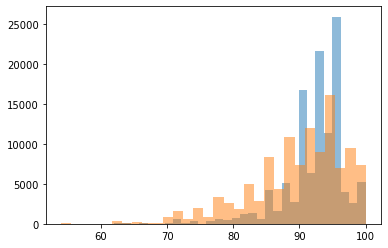

In [ ]:
plt.hist(loaded_model.predict(X_test),bins=30,alpha=0.5)
plt.hist(y_test,bins=30,alpha=0.5)

## average over business reviews

In [59]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [60]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))

In [660]:
# load in feature transforms
filename = model_directory + 'individual_review_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))
# load in model
filename = model_directory + 'individual_review_model_ridge.pkl'
loaded_model = pkl.load(open(filename, 'rb'))

In [661]:
good_reviews = np.array([r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                         r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                         r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                         r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                         r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                         r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                         r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
                        ])

In [662]:
bad_reviews = np.array([r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
                         r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
                         r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
                         r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
                         r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
                         r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
                         r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
                         r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
                         r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever."
                         r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
                       ])

In [663]:
test_out = loaded_features.transform(good_reviews)
np.mean(loaded_model.predict(test_out))

88.62441094001744

In [664]:
test_out = loaded_features.transform(bad_reviews)
np.mean(loaded_model.predict(test_out))

89.39988267628524

In [64]:
loaded_model.predict(test_out)

array([91, 95, 95, 94, 90, 90, 71])

In [261]:
%%time
X_out = loaded_features.transform(X)

Wall time: 1min 59s


In [276]:
y_predict = loaded_model.predict(X_out)

In [292]:
y_predict = regressor.predict(X_out)

In [293]:
from sklearn.metrics import r2_score
r2_score(y, y_predict)

0.12243127750389315

In [294]:
df['predicted_score'] = y_predict

In [306]:
new_df = df.groupby(['business_id']).agg({'Score':'mean','predicted_score':'mean','review_stars':'mean'}).reset_index()

In [307]:
df['Score'].values

array([76., 76., 76., ..., 73., 73., 85.])

In [308]:
sklearn.metrics.r2_score(new_df['Score'].values,new_df['predicted_score'].values)

0.20016462378158562

(array([  3.,   2.,  10.,  12.,  16.,  40.,  35.,  58.,  82., 180., 237.,
        368., 482., 307., 353., 203.,  76.,  26.,   9.,   7.]),
 array([81.53266138, 82.24207659, 82.9514918 , 83.66090701, 84.37032222,
        85.07973743, 85.78915264, 86.49856785, 87.20798306, 87.91739826,
        88.62681347, 89.33622868, 90.04564389, 90.7550591 , 91.46447431,
        92.17388952, 92.88330473, 93.59271994, 94.30213515, 95.01155036,
        95.72096556]),
 <BarContainer object of 20 artists>)

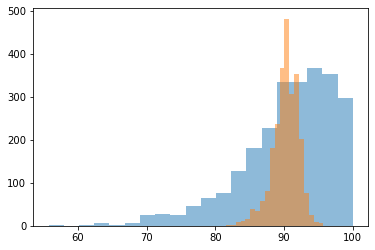

In [309]:
plt.hist(new_df.Score,bins=20,alpha=0.5)
plt.hist(new_df.predicted_score,bins=20,alpha=0.5)

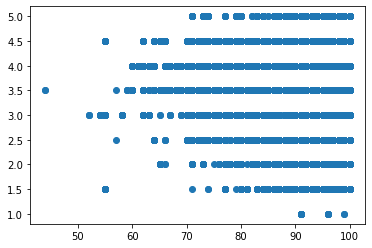

In [310]:
plt.scatter(df['Score'],df['stars'])
plt.show()

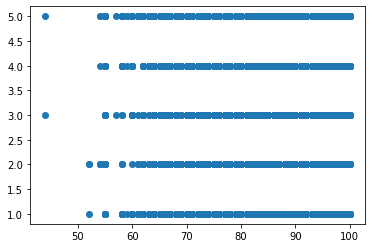

In [311]:
plt.scatter(df['Score'],df['review_stars'])
plt.show()

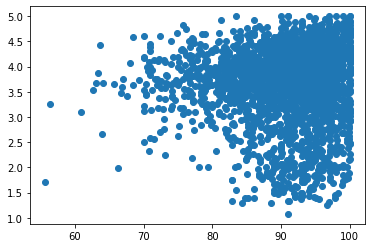

In [312]:
plt.scatter(new_df['Score'],new_df['review_stars'])
plt.show()

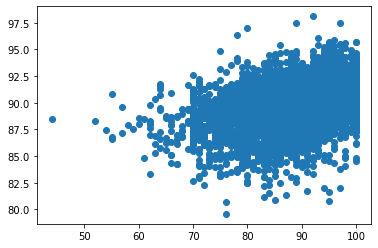

In [301]:
plt.scatter(new_df['Score'],new_df['predicted_score'])
plt.show()

## whole thing

In [652]:
# load in feature transforms
filename = model_directory + 'individual_review_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))
# load in model
filename = model_directory + 'individual_review_model_ridge.pkl'
loaded_model = pkl.load(open(filename, 'rb'))

In [817]:
business_id = 'NRPemqVb4qpWFF0Avq_6OQ'
yelp_api = YelpAPI(api_key, timeout_s=3.0)
response = yelp_api.reviews_query(id=business_id)
response['reviews'][0]['text']

"I've been going here for years - in person or curbside. Always big portions, hot food, and delicious! \n\nThey have a special on wine once a week, which I'm..."

In [818]:
name = 'Shanghai Noodle House'
address = '10300 Anderson Mill Rd, Ste A'

In [819]:
response = yelp_api.business_match_query(name=name,
                                         address1=address,
                                         city='Austin',
                                         state='TX',
                                         country='US')

In [820]:
response

{'businesses': [{'id': 'EaBDXdIQ_TeeUhn1Twnjvg',
   'alias': 'shanghai-noodle-house-austin-2',
   'name': 'Shanghai Noodle House',
   'coordinates': {'latitude': 30.4474449157715,
    'longitude': -97.804328918457},
   'location': {'address1': '10300 Anderson Mill Rd',
    'address2': 'Ste A',
    'address3': '',
    'city': 'Austin',
    'zip_code': '78750',
    'country': 'US',
    'state': 'TX',
    'display_address': ['10300 Anderson Mill Rd',
     'Ste A',
     'Austin, TX 78750']},
   'phone': '+15124875703',
   'display_phone': '(512) 487-5703'}]}

In [821]:
if not response['businesses']:
    print('ok')

In [822]:
response_name = response['businesses'][0]['name']
print(f'Business found: {response_name}')
bid = response['businesses'][0]['id']
# yelp API doesn't give review full text yet
# reviews = yelp_api.reviews_query(id=bid)

Business found: Shanghai Noodle House


In [827]:
bid

'EaBDXdIQ_TeeUhn1Twnjvg'

In [825]:
business_ids

,business_id
0,NRPemqVb4qpWFF0Avq_6OQ
1,bRsDZ44CD3uhGnRY3NeQhQ
2,IFB2K3BEZ2L_Mv5AbUD26Q
3,fBvQQUk1-V9IUA8PbuYFWg
4,eOnMGfoj3YOxGPDjrDE-sg
...,...
2501,kg8MYEVgwvBHDX01V9vm3A
2502,fTgnVCCu6k_Ds25Nz73s5Q
2503,erLD01SfdUbGWurNoJTAzw
2504,io_UQS_WwonlCPCfKy3Hdw


In [831]:
bid in business_ids.business_id.values

True

In [59]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [ ]:
reviews = df[df['business_id'] == bid]['text']

In [ ]:
transformed_reviews = loaded_features.transform(reviews)
predicted_score = np.mean(loaded_model.predict(transformed_reviews))

In [ ]:
print(f'Health score: {predicted_score}')

## word2vec

In [163]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [162]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
cutoff = -1
X, y = reviews[:cutoff], scores[:cutoff]
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))

4184/570613 (0.7332465261043825%) are fractional scores


# other feature engineering

## sentiment analysis

Let's see if running existing sentiment analysis functions can help us at all. In the long run, we want to make a custom sentiment analysis specifically for cleanliness, but we don't have the data to train that on.

In [176]:
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

import nltk
nltk.download(['averaged_perceptron_tagger', 'punkt', 'vader_lexicon'])
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from textblob import TextBlob

def sentiment_analysis_spacy(text):
    return (nlp(text))._.blob.polarity
def sentiment_analysis_nltk(text):
    return sia.polarity_scores(text)['compound']
def sentiment_analysis_tb(text):
    return TextBlob(text).sentiment.polarity

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here are some reviews I got from a gross restaurant: https://www.yelp.com/biz/pacific-star-restaurant-and-oyster-bar-round-rock-3

I expect the bad reviews to be rated pretty lowly. I don't really care about the analysis on the good reviews.

In [177]:
good_reviews = [r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
               ]

In [194]:
bad_reviews = [r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
               r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
               r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
               r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
               r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
               r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
               r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
               r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
               r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
              ]

In [195]:
bad_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, bad_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, bad_reviews)),
    'textblob':list(map(sentiment_analysis_tb, bad_reviews))
})
# function to highlight negative values
def highlight_sign(s):
    if s.dtype == object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:white' 
            for cell in is_neg]
bad_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,-0.145489,0.190100,-0.145489
1,-0.256173,-0.483000,-0.256173
2,-0.016898,-0.497000,-0.016898
3,-0.258333,-0.968800,-0.258333
4,0.118750,-0.232500,0.118750
5,-0.042628,-0.783000,-0.042628
6,-0.008671,-0.624000,-0.008671
7,0.000000,-0.510600,0.000000
8,-0.005407,0.481600,-0.005407


In [189]:
bad_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, bad_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, bad_reviews)),
    'textblob':list(map(sentiment_analysis_tb, bad_reviews))
})
# function to highlight negative values
def highlight_sign(s):
    if s.dtype == object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:white' 
            for cell in is_neg]
bad_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,-0.145489,0.190100,-0.145489
1,-0.256173,-0.483000,-0.256173
2,-0.016898,-0.497000,-0.016898
3,-0.258333,-0.968800,-0.258333
4,0.118750,-0.232500,0.118750
5,-0.042628,-0.783000,-0.042628
6,-0.008671,-0.624000,-0.008671
7,0.000000,-0.510600,0.000000
8,-0.081451,0.435700,-0.081451


In [185]:
good_review_df = pd.DataFrame({
    'spacy':list(map(sentiment_analysis_spacy, good_reviews)),
    'nltk':list(map(sentiment_analysis_nltk, good_reviews)),
    'textblob':list(map(sentiment_analysis_tb, good_reviews))
})
good_review_df.style.apply(highlight_sign)

,spacy,nltk,textblob
0,0.435000,0.957000,0.435000
1,0.533333,0.892200,0.533333
2,0.194792,0.901800,0.194792
3,0.447143,0.968400,0.447143
4,0.457845,0.970900,0.457845
5,0.286091,0.944000,0.286091
6,0.114920,0.945800,0.114920


So textblob and spacytextblob are the same thing, but textblob runs a lot faster. nltk and tb give different answers, though, and these are some really negative reviews. It seems that nltk fails on the first/last reviews which are long whereas tb can't tell about reviews 4 and 7 which makes sense, reading them. Going with textblob.

In [198]:
%%time
df['text'][:10000].apply(sentiment_analysis_tb)

Wall time: 13.3 s


0       0.298052
1       0.466558
2       0.790625
3       0.409615
4       0.461540
          ...   
9995    0.143333
9996    0.052778
9997    0.700000
9998    0.475000
9999    0.550000
Name: text, Length: 10000, dtype: float64

In [202]:
print(f"running this will take {len(df) * 13.3/10000 /60} minutes")

running this will take 12.648610333333332 minutes


In [203]:
df['sentiment'] = df['text'].apply(sentiment_analysis_tb)

In [ ]:
df['review_stars']

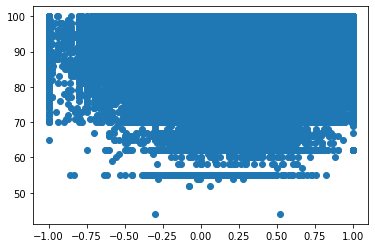

In [212]:
plt.scatter(df.sentiment,df.Score)

In [296]:
def percent_bad_reviews(values):
    return sum(values < 0.25)/len(values)

In [292]:
grouped = df.groupby('business_id')
new_df = grouped.agg(sentiment=('sentiment','mean'),
                     percent_bad_sentiment=('sentiment',percent_bad_reviews),
                     Score=('Score','mean'),
                     review_stars=('review_stars','mean')
                    ).reset_index()

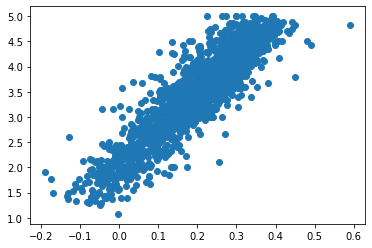

In [287]:
# obvious correlation with review stars
plt.scatter(new_df.sentiment,new_df.review_stars)

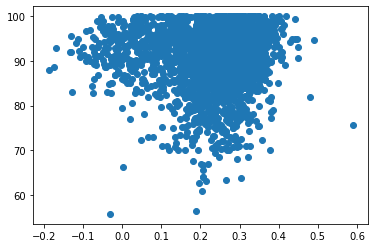

In [288]:
# not much correlation with Score with a straight average
plt.scatter(new_df.sentiment,new_df.Score)

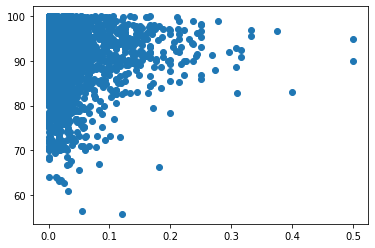

In [297]:
# not much correlation with % bad reviews
plt.scatter(new_df.percent_bad_sentiment,new_df.Score)

## DIRTY_WORDS

Gathering a corpus to describe dirty restaurants from reddit posts by health inspectors talking about their worst ever experiences:
* https://www.reddit.com/r/AskReddit/comments/1lnddh/health_inspectors_of_reddit_what_is_the_worst/
* https://www.reddit.com/r/AskReddit/comments/2h1uuq/food_inspectors_of_reddit_whats_the_worst/

Following this helpful guide: https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

And this post: https://stackoverflow.com/questions/60623349/how-to-limit-first-level-comments-in-praw-reddit

### gather reddit comments

In [328]:
import praw
from praw.models import MoreComments
f = open(data_directory + 'reddit_api_key.txt','r')
r_client_id, r_secret, r_user_agent = [line.strip() for line in f.readlines()]
f.close()
reddit = praw.Reddit(client_id=r_client_id, client_secret=r_secret, user_agent=r_user_agent)

In [516]:
# get all top-level comments in a post
def iter_top_level(comments):
    for top_level_comment in comments:
        if isinstance(top_level_comment, MoreComments):
            yield from iter_top_level(top_level_comment.comments())
        else:
            yield top_level_comment

def get_reddit_comments(post_id="1lnddh"):
    submission = reddit.submission(post_id)
    comments = []
    for comment in iter_top_level(submission.comments): 
        # only get NON-deleted posts with > 2 score to filter out... trash
        if comment.author and comment.score > 2:
            comments.append(comment.body)
    return comments

In [517]:
%%time
comments = []
post_ids = ["1lnddh","2h1uuq","598qrb"]
for i in post_ids:
    comments += get_reddit_comments(i)

Wall time: 55.7 s


In [518]:
comments=np.array(comments)

In [509]:
# fig = plt.figure(1)
# plt.xlim(-30,30)
# plt.ylim(0,100)
# plt.hist(comments[comments < 30],bins=50)
# plt.show()

In [510]:
# # looking at # comments vs. score
# integral_range = range(-30,100,1)
# integral = [sum(comments < x)/len(comments) for x in integral_range]
# plt.plot(integral_range,integral)

In [511]:
# # 90% of comments have positive score. Let's throw out the ones with negative scores
# sum(comments > 0)/len(comments)

In [519]:
filename = processed_data_directory + 'reddit_comments.csv'
comments_df = pd.DataFrame({'comments':comments})
comments_df.to_csv(filename, index=False)

### process reddit comments for vocabulary

In [520]:
filename = processed_data_directory + 'reddit_comments.csv'
comments_df = pd.read_csv(filename)

In [733]:
comments_df.comments

0      Environmental Health Inspectors don't only cov...
1      Going on 10 years as an inspector.  Most dange...
2      Struck up a conversation with the health inspe...
3      I work in the beer industry and some of the wa...
4      If you're eating out at a fast food restaurant...
                             ...                        
402    > Anyways, the place still technically passed ...
403    what the fuck is wrong with you? This is just ...
404    "Forced"?   Are you implying the health inspec...
405    Can confirm. I always order the dookie nut cho...
406    Reposted from [here.](https://www.reddit.com/r...
Name: comments, Length: 407, dtype: object

In [859]:
def a_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if (w.lemma_ not in ['_', '.']) and (w.pos_ not in ['PRON','DET','NUM','AUX','ADP']) ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS
# Removing a few words that don't lemmatize well
stopwords = stopwords.difference({'he','his','her','hers'})

stopwords = set(a_lemmatizer(' '.join(sorted(stopwords))))
# add some annoying ones that get through lemmatizer
stopwords = stopwords.union({'\'s', '\'ll', '\'ve'})

In [587]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sentence = "The striped bats are hanging on their feet for not are best"
doc = nlp(sentence)

for token in doc:
    print(token.text, " -- ", token.pos_, " -- ",token.lemma_)

The  --  DET  --  the
striped  --  VERB  --  stripe
bats  --  NOUN  --  bat
are  --  AUX  --  be
hanging  --  VERB  --  hang
on  --  ADP  --  on
their  --  PRON  --  their
feet  --  NOUN  --  foot
for  --  ADP  --  for
not  --  PART  --  not
are  --  AUX  --  be
best  --  ADJ  --  good


In [588]:
test = comments_df.comments[0]
print(test)
print(my_lemmatizer(test))

Environmental Health Inspectors don't only cover restaurants.  I inspect wells and septic systems.  I see sewage everyday.  The worst thing I've seen are old men coming up to their door naked . . . and what makes it worse is that they knew what date and time I was stopping by.
['environmental', 'health', 'inspectors', 'not', 'only', 'cover', 'restaurant', 'inspect', 'well', 'and', 'septic', 'system', 'see', 'sewage', 'everyday', 'bad', 'thing', 'see', 'old', 'man', 'come', 'door', 'naked', 'and', 'make', 'bad', 'that', 'know', 'date', 'and', 'time', 'stop']


In [845]:
print(df.business_id.unique())

['NRPemqVb4qpWFF0Avq_6OQ' 'bRsDZ44CD3uhGnRY3NeQhQ'
 'IFB2K3BEZ2L_Mv5AbUD26Q' ... 'erLD01SfdUbGWurNoJTAzw'
 'io_UQS_WwonlCPCfKy3Hdw' 'EaBDXdIQ_TeeUhn1Twnjvg']


In [860]:
# simple bag of words
tfidf = TfidfVectorizer(tokenizer = a_lemmatizer,
                        min_df=5, max_df=0.8, max_features=2000,
                        ngram_range=(1,2), stop_words=STOP_WORDS)

In [861]:
tfed = tfidf.fit_transform(comments_df['comments'])

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'regard', 'use'] not in stop_words.
  warnings.warn(


In [863]:
# filename = model_directory + 'reddit_comments_features.pkl'
# pkl.dump(tfidf, open(filename,'wb'))

In [846]:
tfidf

TfidfVectorizer(max_df=0.8, max_features=2000, min_df=5, ngram_range=(1, 2),
                stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another', 'any', ...},
                tokenizer=<function my_lemmatizer at 0x0000020681878820>)

In [608]:
# looking at high tf-idf terms
high_value_terms = dict(zip(tfidf.vocabulary_, tfidf.idf_))
high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=True))
high_value_terms

{'health': 5.219507705176107,
 'sewage': 5.219507705176107,
 'man': 5.219507705176107,
 'come': 5.219507705176107,
 'walk': 5.219507705176107,
 'grease': 5.219507705176107,
 'burger': 5.219507705176107,
 'grill': 5.219507705176107,
 'right': 5.219507705176107,
 'kitchen': 5.219507705176107,
 'fall': 5.219507705176107,
 'find': 5.219507705176107,
 'order': 5.219507705176107,
 'close': 5.219507705176107,
 'restaurant close': 5.219507705176107,
 'bar': 5.219507705176107,
 'new': 5.219507705176107,
 'stuff': 5.219507705176107,
 'deal': 5.219507705176107,
 'class': 5.219507705176107,
 'hand': 5.219507705176107,
 'expect': 5.219507705176107,
 'floor': 5.219507705176107,
 'cool': 5.219507705176107,
 'degree': 5.219507705176107,
 'lettuce': 5.219507705176107,
 'pot': 5.219507705176107,
 'awful': 5.219507705176107,
 'phone': 5.219507705176107,
 'bag': 5.219507705176107,
 'clean': 5.219507705176107,
 'start': 5.219507705176107,
 'money': 5.219507705176107,
 'fry': 5.219507705176107,
 'nasty': 5.

In [877]:
X = df['text']

In [881]:
%%time
X_out = tfidf.transform(X)

Wall time: 4h 13min


In [882]:
X_out

<570614x575 sparse matrix of type '<class 'numpy.float64'>'
	with 9169408 stored elements in Compressed Sparse Row format>

In [884]:
filename = processed_data_directory + 'X_out_reddit_vocab.npz'
scipy.sparse.save_npz(filename,X_out)

In [867]:
filename = processed_data_directory + 'X_out_reddit_vocab.npz'
X_out = scipy.sparse.load_npz(filename)

In [677]:
# check that it worked
# (test - X_out).nnz == 0

In [885]:
X_out_shuff, y_shuff = shuffle(X_out, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_out_shuff, y_shuff, test_size=0.2)

In [886]:
def test_regressor(regressor,print_R2=True,residual_hist=True,predictions_hist=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()

R^2 score: 0.0853079641254344


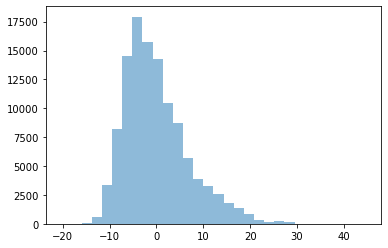

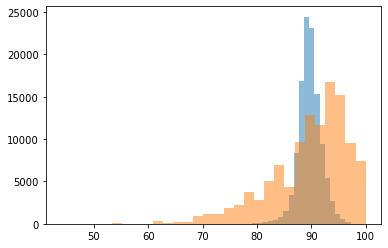

Wall time: 3.2 s


In [887]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

In [888]:
regressor.n_features_in_

575

In [889]:
# filename = model_directory + 'reddit_comments_model.pkl'
# pkl.dump(regressor, open(filename,'wb'))

R^2 score: 0.045521238295048616


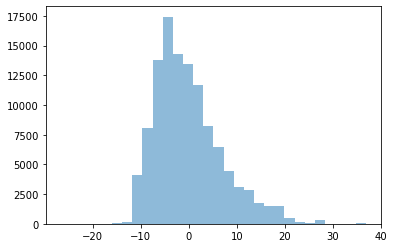

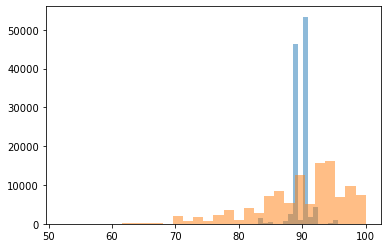

Wall time: 3min 13s


In [716]:
%%time
regressor = ensemble.RandomForestRegressor(n_estimators=100,
                                           max_depth=5,
                                           min_samples_split=5,
                                           min_samples_leaf=3,
                                           n_jobs=-2)
test_regressor(regressor)

R^2 score: 0.03862947869576938


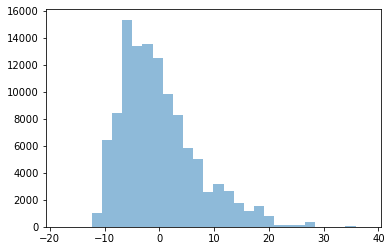

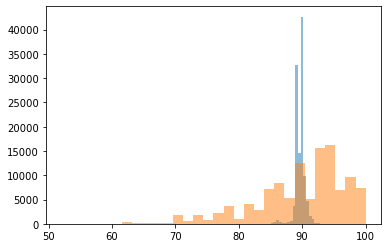

Wall time: 1min 27s


In [719]:
%%time
regressor = ensemble.GradientBoostingRegressor(n_estimators=20,
                                               max_depth=2,
                                               min_samples_split=3,
                                               min_samples_leaf=3)
test_regressor(regressor)

In [721]:
y_predict = regressor.predict(X_out)

In [722]:
df['predicted_score'] = y_predict

In [723]:
new_df = df.groupby(['business_id']).agg({'Score':'mean',
                                          'predicted_score':'mean',
                                          'review_stars':'mean'
                                         }).reset_index()

In [724]:
sklearn.metrics.r2_score(new_df['Score'].values,new_df['predicted_score'].values)

0.1545356470413457

(array([  3.,   3.,   5.,  16.,  27.,  27.,  27.,  71., 202., 288., 367.,
        325., 328., 294., 253., 149.,  70.,  22.,  20.,   9.]),
 array([83.69611653, 84.24768455, 84.79925256, 85.35082058, 85.90238859,
        86.45395661, 87.00552462, 87.55709264, 88.10866065, 88.66022867,
        89.21179668, 89.7633647 , 90.31493271, 90.86650073, 91.41806874,
        91.96963676, 92.52120477, 93.07277279, 93.6243408 , 94.17590882,
        94.72747683]),
 <BarContainer object of 20 artists>)

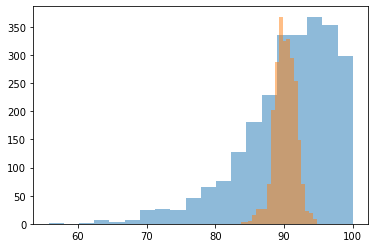

In [725]:
plt.hist(new_df.Score,bins=20,alpha=0.5)
plt.hist(new_df.predicted_score,bins=20,alpha=0.5)

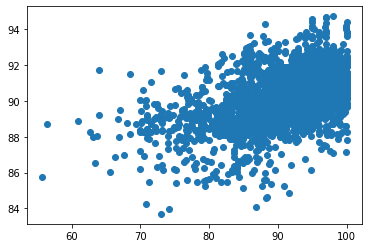

In [727]:
plt.scatter(new_df['Score'],new_df['predicted_score'])
plt.show()

In [728]:
good_reviews = [r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
               ]

In [890]:
bad_reviews = [r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
               r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
               r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
               r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
               r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
               r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
               r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
               r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
               r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
              ]

In [891]:
good_reviews_out = tfidf.transform(good_reviews)
bad_reviews_out = tfidf.transform(bad_reviews)

In [894]:
regressor.predict(good_reviews_out)

array([88.87793138, 86.98901735, 89.229324  , 87.74592685, 89.99735396,
       87.00921956, 88.89329315])

In [892]:
indiv = regressor.predict(bad_reviews_out)

In [893]:
indiv

array([89.32666794, 87.55588409, 88.36502401, 87.04432239, 87.01343715,
       87.75758859, 89.00739414, 85.91950098, 86.66716945])

## Topic modeling/K-means clustering

this doesn't really work

In [734]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

In [735]:
def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS
# Removing a few words that don't lemmatize well
stopwords = stopwords.difference({'he','his','her','hers'})

stopwords = set(my_lemmatizer(' '.join(sorted(stopwords))))
# add some annoying ones that get through lemmatizer
stopwords = stopwords.union({'\'s', '\'ll', '\'ve'})

In [272]:
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

# let's just look at businesses with >100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[num_reviews >= 100].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

# only look at outraged customers
df = df[df.review_stars <= 2]

reviews = df['text']
scores = df['Score']
X, y = shuffle(reviews, scores, random_state=42)
cutoff = -1
X, y = X[:cutoff], y[:cutoff]
# round
roundby = 5
y = y.apply(lambda x: math.ceil(x / roundby) * roundby)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [739]:
# just use reddit data
filename = processed_data_directory + 'reddit_comments.csv'
comments_df = pd.read_csv(filename)
X = comments_df['comments']

In [740]:
%%time
max_features = 1000
cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=2, max_df=0.95, max_features=max_features)
counts = cv.fit_transform(X)

Wall time: 6.81 s


In [741]:
%%time
tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

Wall time: 3 ms


In [775]:
number_of_clusters = 10

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)

KMeans(n_clusters=10, n_init=3, random_state=117)

In [778]:
top_words_df = {'top_words':[[terms[k] for k in cluster_words[i][-number_of_top_words:]] for i in range(number_of_clusters)]}
top_words_df = pd.DataFrame(top_words_df)

In [779]:
top_words_df.top_words[top_words_df.top_words.apply(lambda x: 'dirty' in x)].values

array([list(['dish', 'time', 'mouse', 'pretty', 'phone', 'water', 'place', 'kitchen', 'wash', 'cook', 'chinese', 'dirty', 'clean', 'lettuce', 'chicken', 'chef', 'food', 'work', 'old', 'restaurant'])],
      dtype=object)

In [780]:
'dirty' in top_words

True

In [777]:
number_of_top_words = 20
cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
#     print(f'Cluster {i}: ')
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

inspect hand know place day like rat food chinese bathroom clean good kitchen work inspector health look people eat restaurant 

roach story coffee cream manager owner bad thing clean restaurant itt read shut like know machine piss ice health inspector 

leave glove floor cook manager year kitchen come meat tell food time place health restaurant work day inspector guy his 

restaurant mean story http burger like gov inspection sink kid time context askreddit link www think com https reddit comment 

sink lobster food imgur inside fast html news uk outside inspection health www shut com restaurant find local http rating 

dish time mouse pretty phone water place kitchen wash cook chinese dirty clean lettuce chicken chef food work old restaurant 

inspector currently start asian want safe entire actually sandwich spring food place oh single restaurant today eat chinese read thread 

inspector find like grade week new great dog restaurant chicken cat inspection health buffet year time clo

In [781]:
'dirty' in top_words

True

In [782]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()

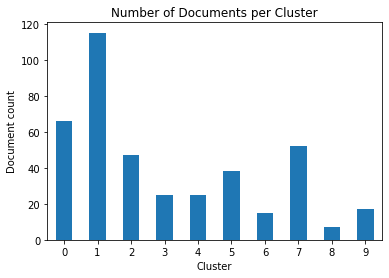

In [783]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

(array([5., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.  , 0.18, 0.36, 0.54, 0.72, 0.9 , 1.08, 1.26, 1.44, 1.62, 1.8 ,
        1.98, 2.16, 2.34, 2.52, 2.7 , 2.88, 3.06, 3.24, 3.42, 3.6 , 3.78,
        3.96, 4.14, 4.32, 4.5 , 4.68, 4.86, 5.04, 5.22, 5.4 , 5.58, 5.76,
        5.94, 6.12, 6.3 , 6.48, 6.66, 6.84, 7.02, 7.2 , 7.38, 7.56, 7.74,
        7.92, 8.1 , 8.28, 8.46, 8.64, 8.82, 9.  ]),
 <BarContainer object of 50 artists>)

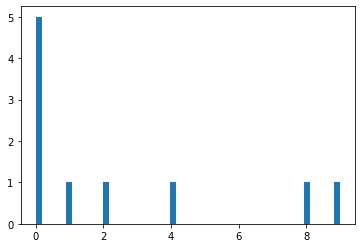

In [787]:
plt.hist(word_df.groupby('Cluster').agg({'dirty':'sum'}),bins = 50)

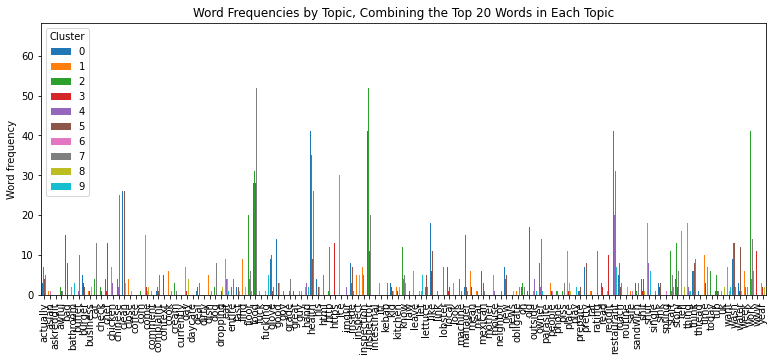

In [788]:
word_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(13,5), width=0.7).\
    set(ylabel='Word frequency', 
    title=f'Word Frequencies by Topic, Combining the Top {number_of_top_words} Words in Each Topic');

In [789]:
word_totals = { i: word_df.groupby('Cluster').sum().loc[i].to_dict() for i in range(number_of_clusters) }

In [791]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=number_of_clusters-1, step=1, value=0, description='Topic')
# interact(show_wordcloud, topic=slider);